In [226]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [227]:
PATH = 'data/newest_data/'

In [228]:
close = pd.read_csv(PATH + 'close.csv', index_col='open_time')
close.index = pd.to_datetime(close.index)

open = pd.read_csv(PATH + 'open.csv', index_col='open_time')
open.index = pd.to_datetime(open.index)

high = pd.read_csv(PATH + 'high.csv', index_col='open_time')
high.index = pd.to_datetime(high.index)

low = pd.read_csv(PATH + 'low.csv', index_col='open_time')
low.index = pd.to_datetime(low.index)

qvolume = pd.read_csv(PATH + 'qvolume.csv', index_col='open_time')
qvolume.index = pd.to_datetime(qvolume.index)

data = {}

for ticker in tqdm(close.columns):
  data[ticker] = {
    'close': close[ticker],
    'open': open[ticker],
    'high': high[ticker],
    'low': low[ticker],
    'volume': qvolume[ticker]
  }
  data[ticker] = pd.DataFrame(data[ticker], index = close.index)

del close, open, high, low, qvolume

  0%|          | 0/9 [00:00<?, ?it/s]

In [229]:
all_pnls = {}
all_pnls_taker = {}
all_pnls_maker = {}

for ticker in tqdm(data.keys()):
    train_data = data[ticker].iloc[:-600]

    # Параметры скользящих средних
    short_window = 7
    long_window = 21

    # Рассчитываем скользящие средние
    train_data['short_ma'] = train_data['close'].rolling(window=short_window, min_periods=1).mean()
    train_data['long_ma'] = train_data['close'].rolling(window=long_window, min_periods=1).mean()

    # Определим сигналы
    train_data['signal'] = np.where(train_data['short_ma'] > train_data['long_ma'], 1, -1)

    # Определим моменты, когда сигнал меняется (золотой крест и крест смерти)
    train_data['position'] = train_data['signal'].diff()

    # Симулируем торговую стратегию с TP и SL
    initial_balance = 100000  # начальный баланс
    balance = initial_balance
    position = 0  # текущая позиция (1 - лонг, -1 - шорт, 0 - без позиции)

    def calculate_support_resistance_levels(data, window=5):
        # Уровень сопротивления (максимум за окно)
        data['resistance_level'] = data['high'].rolling(window=window).max() * 1.001
        # Уровень поддержки (минимум за окно)
        data['support_level'] = data['low'].rolling(window=window).min() * 0.999
        return data

    # Рассчитаем уровни поддержки и сопротивления
    train_data = calculate_support_resistance_levels(train_data)

    # Модифицируем симуляцию торговой стратегии с учетом уровней tp и sl
    initial_balance = 100000
    balance = initial_balance
    position = 0
    entry_price = None
    pnl_list = []
    pnl_list_taker = []
    pnl_list_maker = []
    time_list = []
    risk_reward_ratio = 50  # соотношение риск/прибыль 1:4

    for index, row in train_data.iterrows():
        if row['position'] == 2 and position == 0:  # Золотой крест - открываем лонг
            entry_price = row['close']
            position = 1
            sl = entry_price - (row['resistance_level'] - entry_price) / risk_reward_ratio  # уровень stop-loss
            tp = row['resistance_level']  # уровень take-profit
            
        elif row['position'] == -2 and position == 1:  # Крест смерти - закрываем лонг
            exit_price = row['close']
            pnl = (exit_price - entry_price) / entry_price
            balance += balance * pnl
            pnl_list.append(pnl)
            pnl_list_taker.append(pnl - 0.0004)
            pnl_list_maker.append(pnl - 0.0002)
            time_list.append(index)
            position = 0
        
        elif position == 1:
            # Проверка достижения TP или SL по high и low
            if row['high'] >= tp:  # Достижение take-profit
                exit_price = tp
                pnl = (exit_price - entry_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0
            elif row['low'] <= sl:  # Достижение stop-loss
                exit_price = sl
                pnl = (exit_price - entry_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0
            
        elif row['position'] == -2 and position == 0:  # Крест смерти - открываем шорт
            entry_price = row['close']
            position = -1
            sl = entry_price + (entry_price - row['support_level']) / risk_reward_ratio  # уровень stop-loss
            tp = row['support_level']  # уровень take-profit
            
        elif row['position'] == 2 and position == -1:  # Золотой крест - закрываем шорт
            exit_price = row['close']
            pnl = (entry_price - exit_price) / entry_price
            balance += balance * pnl
            pnl_list.append(pnl)
            pnl_list_taker.append(pnl - 0.0004)
            pnl_list_maker.append(pnl - 0.0002)
            time_list.append(index)
            position = 0
        
        elif position == -1:
            # Проверка достижения TP или SL по high и low
            if row['low'] <= tp:  # Достижение take-profit
                exit_price = tp
                pnl = (entry_price - exit_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0
            elif row['high'] >= sl:  # Достижение stop-loss
                exit_price = sl
                pnl = (entry_price - exit_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0

    # Результаты стратегии
    total_pnl = pd.Series(pnl_list, index=time_list)
    total_pnl_taker = pd.Series(pnl_list_taker, index=time_list)
    total_pnl_maker = pd.Series(pnl_list_maker, index=time_list)
    all_pnls[ticker] = total_pnl
    all_pnls_maker[ticker] = total_pnl_maker
    all_pnls_taker[ticker] = total_pnl_taker

  0%|          | 0/9 [00:00<?, ?it/s]

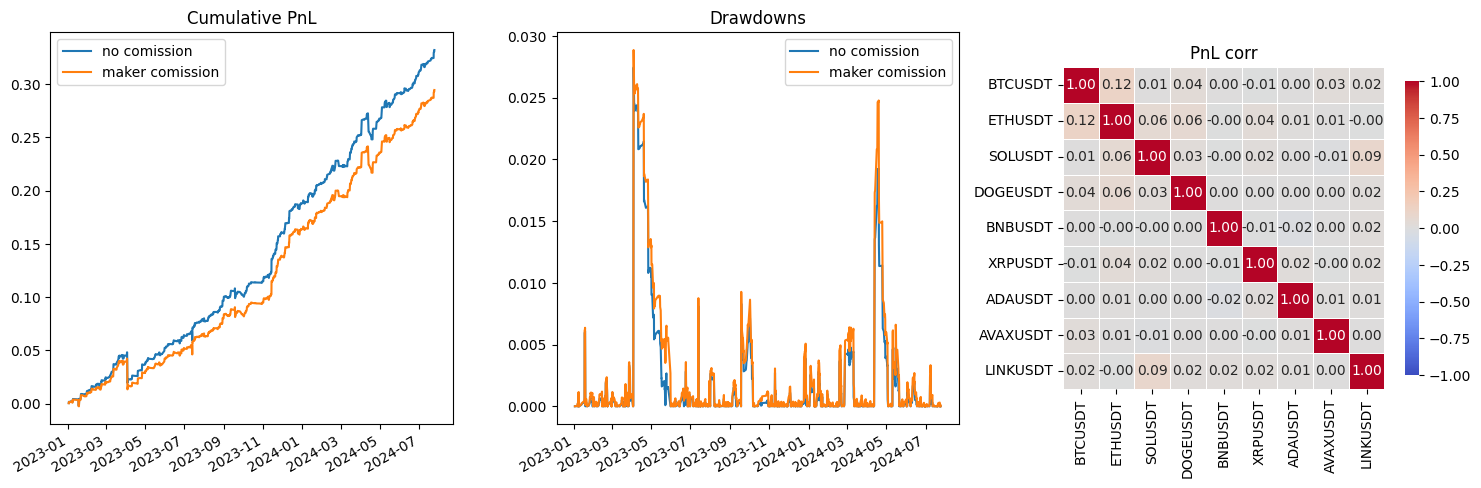

In [230]:
LEVERAGE = 1

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

(pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1).plot(ax=axes[0], label='no comission')
(pd.DataFrame(all_pnls_maker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).plot(ax=axes[0], label='maker comission')
# (pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).plot(ax=axes[0], label='taker comission')
(
  (
    ((pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() - \
    (pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1)) * LEVERAGE
  ) / ((pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() + 1)
).plot(ax=axes[1], label='no comission')
(
  (
    ((pd.DataFrame(all_pnls_maker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() - \
    (pd.DataFrame(all_pnls_maker) * LEVERAGE).fillna(0).cumsum().mean(axis=1)) * LEVERAGE
  )
).plot(ax=axes[1], label='maker comission')
# (
#   (
#     ((pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() - \
#     (pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1)) * LEVERAGE
#   ) / ((pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() + 1)
# ).plot(ax=axes[1], label='taker comission')

corr_matrix = (pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).corr()
sns.heatmap(
    corr_matrix,                   # Матрица корреляций
    annot=True,                    # Показываем значения корреляции
    fmt=".2f",                     # Формат значений (2 знака после запятой)
    cmap="coolwarm",               # Цветовая палитра (можете выбрать другую, например 'viridis')
    vmin=-1, vmax=1,               # Лимиты цветовой шкалы
    square=True,                   # Квадратные ячейки
    linewidths=0.5,                # Толщина линий сетки
    cbar_kws={"shrink": .75},      # Настройка цветовой полоски
    ax=axes[2]
)


axes[0].set_title("Cumulative PnL")
axes[0].legend()
axes[1].set_title("Drawdowns")
axes[1].legend()
axes[2].set_title("PnL corr")

fig.tight_layout()
plt.show()

In [231]:
all_pnls = {}
all_pnls_taker = {}
all_pnls_maker = {}

for ticker in tqdm(data.keys()):
    train_data = data[ticker].iloc[-600:]

    # Параметры скользящих средних
    short_window = 7
    long_window = 21

    # Рассчитываем скользящие средние
    train_data['short_ma'] = train_data['close'].rolling(window=short_window, min_periods=1).mean()
    train_data['long_ma'] = train_data['close'].rolling(window=long_window, min_periods=1).mean()

    # Определим сигналы
    train_data['signal'] = np.where(train_data['short_ma'] > train_data['long_ma'], 1, -1)

    # Определим моменты, когда сигнал меняется (золотой крест и крест смерти)
    train_data['position'] = train_data['signal'].diff()

    # Симулируем торговую стратегию с TP и SL
    initial_balance = 100000  # начальный баланс
    balance = initial_balance
    position = 0  # текущая позиция (1 - лонг, -1 - шорт, 0 - без позиции)

    def calculate_support_resistance_levels(data, window=5):
        # Уровень сопротивления (максимум за окно)
        data['resistance_level'] = data['high'].rolling(window=window).max() * 1.001
        # Уровень поддержки (минимум за окно)
        data['support_level'] = data['low'].rolling(window=window).min() * 0.999
        return data

    # Рассчитаем уровни поддержки и сопротивления
    train_data = calculate_support_resistance_levels(train_data)

    # Модифицируем симуляцию торговой стратегии с учетом уровней tp и sl
    initial_balance = 100000
    balance = initial_balance
    position = 0
    entry_price = None
    pnl_list = []
    pnl_list_taker = []
    pnl_list_maker = []
    time_list = []
    risk_reward_ratio = 50  # соотношение риск/прибыль 1:4

    for index, row in train_data.iterrows():
        if row['position'] == 2 and position == 0:  # Золотой крест - открываем лонг
            entry_price = row['close']
            position = 1
            sl = entry_price - (row['resistance_level'] - entry_price) / risk_reward_ratio  # уровень stop-loss
            tp = row['resistance_level']  # уровень take-profit
            
        elif row['position'] == -2 and position == 1:  # Крест смерти - закрываем лонг
            exit_price = row['close']
            pnl = (exit_price - entry_price) / entry_price
            balance += balance * pnl
            pnl_list.append(pnl)
            pnl_list_taker.append(pnl - 0.0004)
            pnl_list_maker.append(pnl - 0.0002)
            time_list.append(index)
            position = 0
        
        elif position == 1:
            # Проверка достижения TP или SL по high и low
            if row['high'] >= tp:  # Достижение take-profit
                exit_price = tp
                pnl = (exit_price - entry_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0
            elif row['low'] <= sl:  # Достижение stop-loss
                exit_price = sl
                pnl = (exit_price - entry_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0
            
        elif row['position'] == -2 and position == 0:  # Крест смерти - открываем шорт
            entry_price = row['close']
            position = -1
            sl = entry_price + (entry_price - row['support_level']) / risk_reward_ratio  # уровень stop-loss
            tp = row['support_level']  # уровень take-profit
            
        elif row['position'] == 2 and position == -1:  # Золотой крест - закрываем шорт
            exit_price = row['close']
            pnl = (entry_price - exit_price) / entry_price
            balance += balance * pnl
            pnl_list.append(pnl)
            pnl_list_taker.append(pnl - 0.0004)
            pnl_list_maker.append(pnl - 0.0002)
            time_list.append(index)
            position = 0
        
        elif position == -1:
            # Проверка достижения TP или SL по high и low
            if row['low'] <= tp:  # Достижение take-profit
                exit_price = tp
                pnl = (entry_price - exit_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0
            elif row['high'] >= sl:  # Достижение stop-loss
                exit_price = sl
                pnl = (entry_price - exit_price) / entry_price
                balance += balance * pnl
                pnl_list.append(pnl)
                pnl_list_taker.append(pnl - 0.0004)
                pnl_list_maker.append(pnl - 0.0002)
                time_list.append(index)
                position = 0

    # Результаты стратегии
    total_pnl = pd.Series(pnl_list, index=time_list)
    total_pnl_taker = pd.Series(pnl_list_taker, index=time_list)
    total_pnl_maker = pd.Series(pnl_list_maker, index=time_list)
    all_pnls[ticker] = total_pnl
    all_pnls_maker[ticker] = total_pnl_maker
    all_pnls_taker[ticker] = total_pnl_taker

  0%|          | 0/9 [00:00<?, ?it/s]

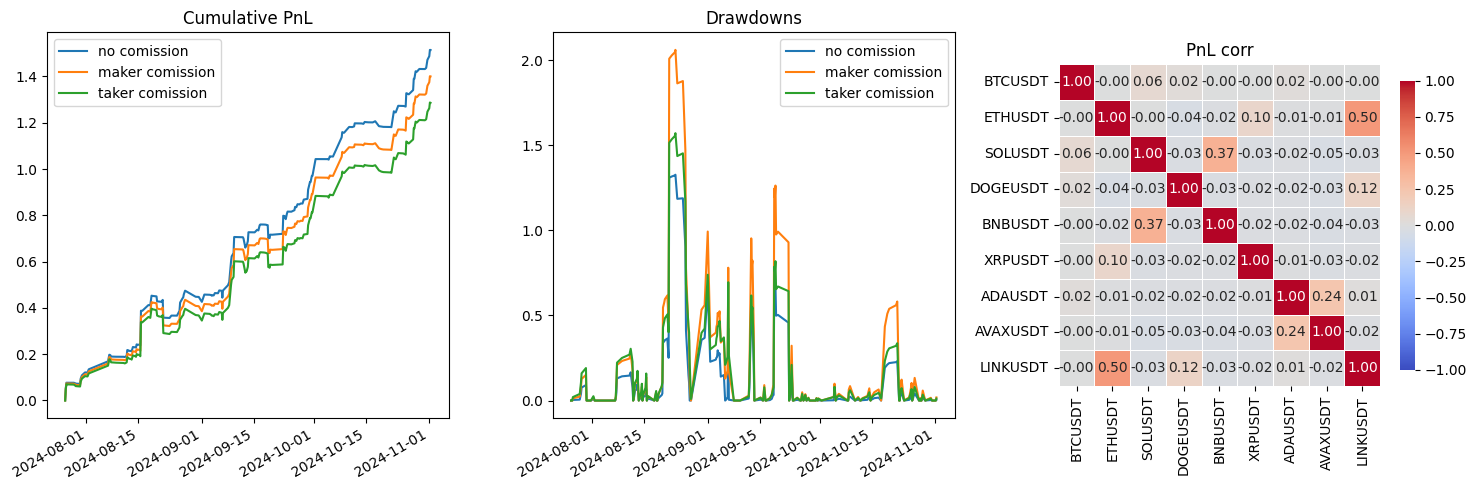

In [240]:
LEVERAGE = 20

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

(pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1).plot(ax=axes[0], label='no comission')
(pd.DataFrame(all_pnls_maker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).plot(ax=axes[0], label='maker comission')
(pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).plot(ax=axes[0], label='taker comission')
(
  (
    ((pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() - \
    (pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1)) * LEVERAGE
  ) / ((pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() + 1)
).plot(ax=axes[1], label='no comission')
(
  (
    ((pd.DataFrame(all_pnls_maker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() - \
    (pd.DataFrame(all_pnls_maker) * LEVERAGE).fillna(0).cumsum().mean(axis=1)) * LEVERAGE
  )
).plot(ax=axes[1], label='maker comission')
(
  (
    ((pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() - \
    (pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1)) * LEVERAGE
  ) / ((pd.DataFrame(all_pnls_taker) * LEVERAGE).fillna(0).cumsum().mean(axis=1).cummax() + 1)
).plot(ax=axes[1], label='taker comission')

corr_matrix = (pd.DataFrame(all_pnls) * LEVERAGE).fillna(0).corr()
sns.heatmap(
    corr_matrix,                   # Матрица корреляций
    annot=True,                    # Показываем значения корреляции
    fmt=".2f",                     # Формат значений (2 знака после запятой)
    cmap="coolwarm",               # Цветовая палитра (можете выбрать другую, например 'viridis')
    vmin=-1, vmax=1,               # Лимиты цветовой шкалы
    square=True,                   # Квадратные ячейки
    linewidths=0.5,                # Толщина линий сетки
    cbar_kws={"shrink": .75},      # Настройка цветовой полоски
    ax=axes[2]
)


axes[0].set_title("Cumulative PnL")
axes[0].legend()
axes[1].set_title("Drawdowns")
axes[1].legend()
axes[2].set_title("PnL corr")

fig.tight_layout()
plt.show()